# 오토인코더(Auto Encoder)

## 바닐라 오토인코더(Vanilla Auto Encoder) 예제

In [74]:
import tensorflow.keras as k
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class Encoder(k.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = k.layers.Dense(units=hidden_dim, activation=tf.nn.relu)

    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

class Decoder(k.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = k.layers.Dense(units=original_dim, activation=tf.nn.relu)

    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

class AutoEncoder(k.Model):
    def __init__(self, hidden_dim, original_dim):
        super(AutoEncoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim=original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [70]:
# 랜덤 계산용 시드 설정
np.random.seed(11)
tf.random.set_seed(11)
# 상수 정의
batch_size = 256
max_epochs = 50
learning_rate = 1e-3  # 0.001
momentum = 8e-1  # 0.8
hidden_dim = 128
original_dim = 784

In [72]:
# 데이터 불러오기
(x_train, _), (x_test, _) = k.datasets.mnist.load_data()
# 데이터셋 0~1사이로 정규화
x_train = x_train / 255.
x_test = x_test / 255.
# 데이터 타입 선언
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
# 28 x 28 데이터를 784로 변환
x_train = np.reshape(x_train, (x_train.shape[0], original_dim))
x_test = np.reshape(x_test, (x_test.shape[0], original_dim))
# 데이터셋을 첸서플로 데이터셋으로 변형
training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

print(x_train.shape, x_train[0])

11493376/11490434 [==============================] - 1s 0us/step
(60000, 784) [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [79]:
autoencoder = AutoEncoder(hidden_dim=hidden_dim, original_dim=original_dim)
optimizer = k.optimizers.Adam(learning_rate=1e-2)

def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
        gradients = tape.gradient(reconstruction_error, model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
    
    opt.apply_gradients(gradient_variables)
    return reconstruction_error

def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [80]:
train_loop(autoencoder, optimizer, loss, training_dataset, epochs=max_epochs)

Epoch 1/50. Loss: 5.065715312957764
Epoch 2/50. Loss: 3.034809112548828
Epoch 3/50. Loss: 2.919581651687622
Epoch 4/50. Loss: 2.834174871444702
Epoch 5/50. Loss: 2.8429641723632812
Epoch 6/50. Loss: 2.7698400020599365
Epoch 7/50. Loss: 2.798651933670044
Epoch 8/50. Loss: 2.7742960453033447
Epoch 9/50. Loss: 2.773048162460327
Epoch 10/50. Loss: 2.766547679901123
Epoch 11/50. Loss: 2.7664947509765625
Epoch 12/50. Loss: 2.7588257789611816
Epoch 13/50. Loss: 2.7236874103546143
Epoch 14/50. Loss: 2.7241709232330322
Epoch 15/50. Loss: 2.722588539123535
Epoch 16/50. Loss: 2.733405828475952
Epoch 17/50. Loss: 2.7761733531951904
Epoch 18/50. Loss: 2.736358880996704
Epoch 19/50. Loss: 2.7359304428100586
Epoch 20/50. Loss: 2.7196154594421387
Epoch 21/50. Loss: 2.7274396419525146
Epoch 22/50. Loss: 2.739013433456421
Epoch 23/50. Loss: 2.7474474906921387
Epoch 24/50. Loss: 2.7230708599090576
Epoch 25/50. Loss: 2.7219290733337402
Epoch 26/50. Loss: 2.7066643238067627
Epoch 27/50. Loss: 2.73286581039

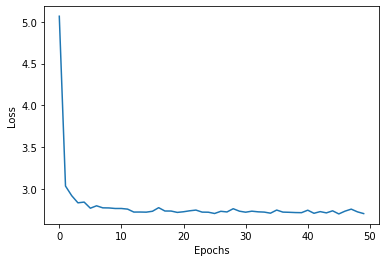

In [81]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

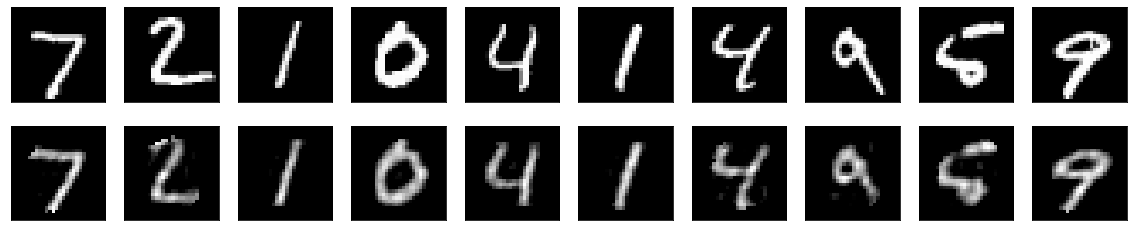

In [82]:
number = 10  # 표시하려는 숫자의 개수
plt.figure(figsize=(20,4))
for index in range(number):
    # 원래 이미지 표시
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 이미지 표시
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 희소 오토인코더(Sparse Auto Encoder) 예제
- Encoder 부분의 Dense 계층에 추가 매개변수 activity_regularizer를 추가하면 바닐라 오토인코더에서 희소 오토인코더를 얻을수 있다.

In [83]:
import tensorflow.keras as k
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

## 이 부분만 변경됨 ##
class Encoder(k.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = k.layers.Dense(units=hidden_dim, activity_regularizer=regularizers.l1(10e-5), activation=tf.nn.relu)
        # 추가된 부분 : activity_regularizer=regularizers.l1(10e-5)

    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

class Decoder(k.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = k.layers.Dense(units=original_dim, activation=tf.nn.relu)

    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

class AutoEncoder(k.Model):
    def __init__(self, hidden_dim, original_dim):
        super(AutoEncoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim=original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

# 랜덤 계산용 시드 설정
np.random.seed(11)
tf.random.set_seed(11)
# 상수 정의
batch_size = 256
max_epochs = 50
learning_rate = 1e-3  # 0.001
momentum = 8e-1  # 0.8
hidden_dim = 128
original_dim = 784

# 데이터 불러오기
(x_train, _), (x_test, _) = k.datasets.mnist.load_data()
# 데이터셋 0~1사이로 정규화
x_train = x_train / 255.
x_test = x_test / 255.
# 데이터 타입 선언
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
# 28 x 28 데이터를 784로 변환
x_train = np.reshape(x_train, (x_train.shape[0], original_dim))
x_test = np.reshape(x_test, (x_test.shape[0], original_dim))
# 데이터셋을 첸서플로 데이터셋으로 변형
training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

autoencoder = AutoEncoder(hidden_dim=hidden_dim, original_dim=original_dim)
optimizer = k.optimizers.Adam(learning_rate=1e-2)

def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
        gradients = tape.gradient(reconstruction_error, model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
    
    opt.apply_gradients(gradient_variables)
    return reconstruction_error

def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [84]:
train_loop(autoencoder, optimizer, loss, training_dataset, epochs=max_epochs)

Epoch 1/50. Loss: 5.1591596603393555
Epoch 2/50. Loss: 3.059004068374634
Epoch 3/50. Loss: 2.9568607807159424
Epoch 4/50. Loss: 2.918431282043457
Epoch 5/50. Loss: 2.8699724674224854
Epoch 6/50. Loss: 2.854269027709961
Epoch 7/50. Loss: 2.852221965789795
Epoch 8/50. Loss: 2.8432018756866455
Epoch 9/50. Loss: 2.8672866821289062
Epoch 10/50. Loss: 2.8165907859802246
Epoch 11/50. Loss: 2.8183085918426514
Epoch 12/50. Loss: 2.8219194412231445
Epoch 13/50. Loss: 2.809661865234375
Epoch 14/50. Loss: 2.823544979095459
Epoch 15/50. Loss: 2.8267922401428223
Epoch 16/50. Loss: 2.801837682723999
Epoch 17/50. Loss: 2.8172099590301514
Epoch 18/50. Loss: 2.8341853618621826
Epoch 19/50. Loss: 2.7959303855895996
Epoch 20/50. Loss: 2.803976058959961
Epoch 21/50. Loss: 2.802311658859253
Epoch 22/50. Loss: 2.8057894706726074
Epoch 23/50. Loss: 2.8167505264282227
Epoch 24/50. Loss: 2.815363883972168
Epoch 25/50. Loss: 2.807546615600586
Epoch 26/50. Loss: 2.7923192977905273
Epoch 27/50. Loss: 2.81959223747

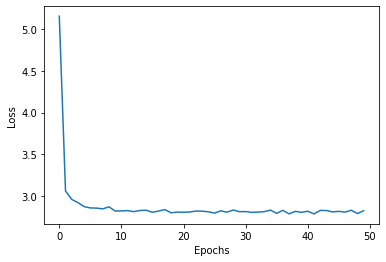

In [85]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

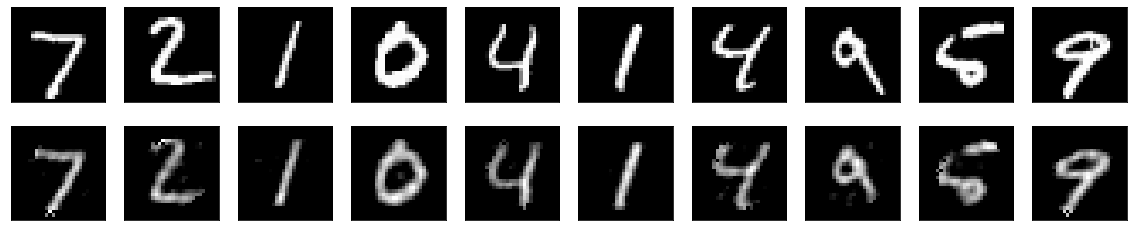

In [86]:
number = 10  # 표시하려는 숫자의 개수
plt.figure(figsize=(20,4))
for index in range(number):
    # 원래 이미지 표시
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 이미지 표시
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 디노이징 오토인코더(Denoising Auto Encoder) 예제

#### 1. 필요한 모듈을 임포트

In [88]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt

#### 2.모델의 초 매개변수를 정의

In [96]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3  # 0.001
momentum = 8e-1  # 0.8
hidden_dim = 128
original_dim = 784

#### 3. MNIST 데이터셋을 읽고 정규화한 후 노이즈를 첨가한다.

In [107]:
(x_train, _), (x_test, _) = k.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (x_train.shape[0], original_dim))
x_test = np.reshape(x_test, (x_test.shape[0], original_dim))

# 정규분포를 가진 노이즈를 첨가해 왜곡된 MNIST 이미지 생성
# 정규분포의 평균과 표준편차는 0.5다.
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#### 4. '바닐라 오토인코더' 절에 있는 것과 동일한 인코더, 디코더, 오토인코더 부류를 사용한다.

In [108]:
# 인코더
class Encoder(k.layers.Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = k.layers.Dense(units=hidden_dim, activation=tf.nn.relu)

    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

# 디코더
class Decoder(k.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = k.layers.Dense(units=original_dim, activation=tf.nn.relu)

    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

# 오토인코더
class AutoEncoder(k.Model):
    def __init__(self, hidden_dim, original_dim):
        super(AutoEncoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, original_dim=original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

#### 5. 다음으로 모델을 생성하고 사용할 손실과 치적화기를 정의한다. 이번에는 사용자 정의 훈련 루프 대신 더 쉬운 케라스의 내장 메소드인 compile()과 fit()을 쓴다는 점에 유의하자.

In [109]:
model = AutoEncoder(hidden_dim=hidden_dim, original_dim=original_dim)
model.compile(loss='mse', optimizer='adam')
loss = model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=max_epochs, batch_size=batch_size)

Epoch 1/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0515 - val_loss: 0.0340
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0304 - val_loss: 0.0274
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0267 - val_loss: 0.0257
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0257 - val_loss: 0.0251
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0251 - val_loss: 0.0246
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0248 - val_loss: 0.0243
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0246 - val_loss: 0.0242
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0245 - val_loss: 0.0241
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0245 - val_loss: 0.0240

#### 6. 이제 훈련 손실을 도식화해보자.

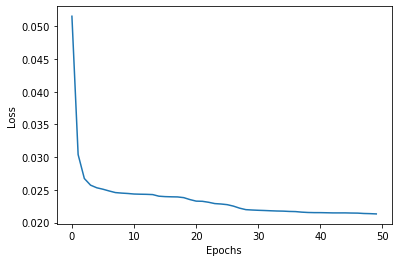

In [110]:
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### 7. 마지막으로 모델이 작동되는 것을 살펴보자. 상단 행은 입력 노이즈 이미지를 보여주고 하단의 행은 디노이징 오토인코더로 훈련해 또렷하게 처리한 이미지다.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



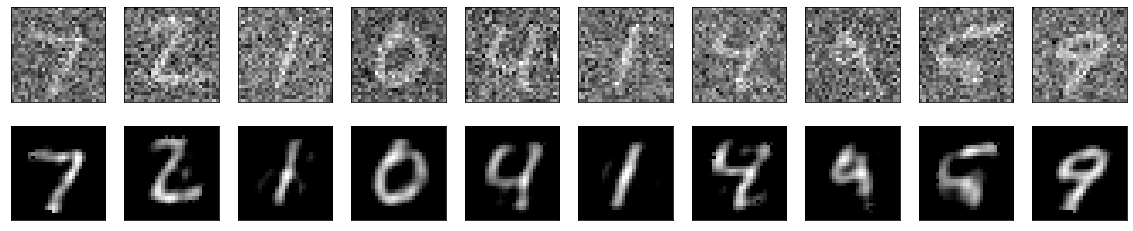

In [111]:
number = 10  # 표시하려는 숫자의 개수
plt.figure(figsize=(20, 4))
for index in range(number):
    # 원래 이미지 표시
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성 이미지 표시
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test_noisy)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 스택된 오토인코더(Convolution Auto Encoder) 예제
- 인코더와 디코더 모두 여러 계층을 쌓으면 심층 오토인코더를 구축할 수 있다. 이러한 오토인코더를 스택된 오토인코더라 부른다.
- 스택된 오토인코더는 재구성 오타를 최소화 하기 위한 신경망 전체로 훈련될 수 있다. 또는 각 개별 인코더/디코더 신경망을 먼저 이전에 배운 비지도 기법을 사용해 사전 훈련한 후 전체 신경망을 미세 저정할 수도 있다.

#### 1. 필요한 모듈을 임포트한다. 또한 편의상 tensorflow.keras.layers에서 특정 계층을 임포트한다.

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D

#### 2. 초 매개변수를 지정한다. 주의 깊게 살펴보면 리스트가 약간 다르다. 이전의 오토인코더 구현과 비교하면 학습률과 모멘텀 대신 이번에는 컨볼루션 계층의 필터와 관련이 있다.

In [3]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 128
max_epochs = 50
filters = [32,32,16]

#### 3. 데이터를 읽고 전처리한다. 노이즈를 추가한 방식과 (0-1) 사이에서 범위를 제한하는 것에서 차이가 난다. 평균 제곱 오차 손실 대신 이진 교차 엔트로피 손실을 사용하고, 또한 디코더의 최종 출력은 시그모이드 활성화를 통과할 것이기 때문에 (0-1) 사이로 제한한다.

In [4]:
(x_train, _), (x_test, _) = k.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = 0.5
x_train_noisy = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')

print(x_train_noisy.shape)

(60000, 28, 28, 1)


#### 4. 이제 인코더를 정의한다. 인코더는 3개의 컨볼루션 계층으로 구성되고 각 계층에는 최대풀링 계층이 있다. MNIST 데이터셋을 사용하고 있기 때문에 입력 이미지의 모양은 28 x 28(단일 채널)이고 출력 이미지의 크기는 4 x 4(마지막 컨볼루션 계층에는 16개의 필터가 있으므로 이미지에는 16개의 채널이 있다.)

In [5]:
class Encoder(k.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.pool = MaxPool2D((2, 2), padding='same')

    def call(self, input_features):
        x = self.conv1(input_features)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

#### 5. 다음은 디코더다. 디코더는 설계상 정확히 반대되고 최대 풀링 대신 다시 크기를 증가시키고자 업샘플링을 사용한다.

In [6]:
class Decoder(k.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='valid')
        self.conv4 = Conv2D(filters=1, kernel_size=3, strides=1, activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2,2))

    def call(self, encoded):
        x = self.conv1(encoded)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        return self.conv4(x)

#### 6. 인코더와 디코더를 합쳐 오토인코더 모델을 만들었다. 이는 이전과 완전히 똑같다.

In [7]:
class AutoEncoder(k.Model):
    def __init__(self, filters):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)

    def call(self, input_features):
        #print(input_features.shape)
        encoded = self.encoder(input_features)
        #print(encoded.shape)
        reconstructed = self.decoder(encoded)
        return reconstructed

#### 7. 이제 모델을 인스턴스화한 다음 손실 함수로 이진 교차 엔트로피를 지정하고 compile()메소드에서 최적화기로 Adam을 지정한다. 그런 다음 모델을 훈련 데이터셋에 적합화한다.

In [8]:
model = AutoEncoder(filters)
model.compile(loss='binary_crossentropy', optimizer='adam')
loss = model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=max_epochs, batch_size=batch_size)

Epoch 1/50
469/469 [==============================] - 67s 142ms/step - loss: 0.2046 - val_loss: 0.1505
Epoch 2/50
469/469 [==============================] - 67s 142ms/step - loss: 0.1415 - val_loss: 0.1318
Epoch 3/50
469/469 [==============================] - 66s 141ms/step - loss: 0.1283 - val_loss: 0.1234
Epoch 4/50
469/469 [==============================] - 66s 141ms/step - loss: 0.1218 - val_loss: 0.1191
Epoch 5/50
469/469 [==============================] - 66s 140ms/step - loss: 0.1178 - val_loss: 0.1154
Epoch 6/50
469/469 [==============================] - 66s 140ms/step - loss: 0.1150 - val_loss: 0.1131
Epoch 7/50
469/469 [==============================] - 65s 139ms/step - loss: 0.1126 - val_loss: 0.1108
Epoch 8/50
469/469 [==============================] - 66s 140ms/step - loss: 0.1110 - val_loss: 0.1089
Epoch 9/50
469/469 [==============================] - 67s 142ms/step - loss: 0.1095 - val_loss: 0.1079
Epoch 10/50
469/469 [==============================] - 67s 143ms/step - l

#### 8. 모델의 훈련에 따른 손실 곡선을 볼 수 있다. 50에폭에서 손실은 0.0987로 축소됐다.

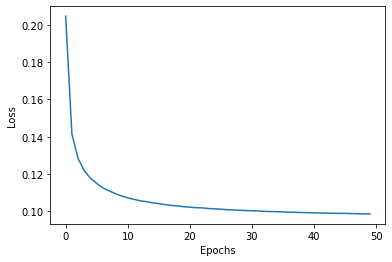

In [9]:
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### 9. 마지막으로 노이즈가 있는 입력 이미지에서 재구성된 멋진 이미지를 볼 수 있다.

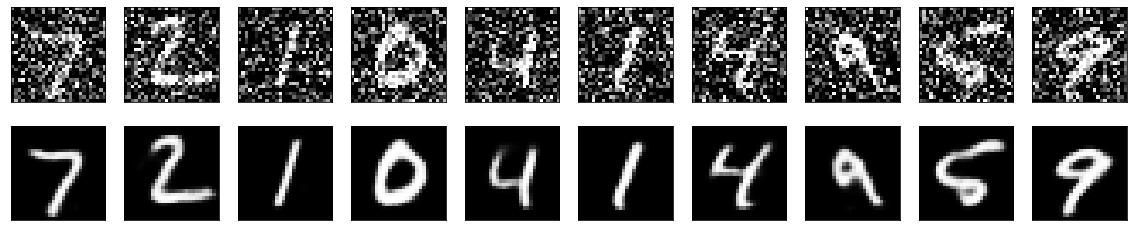

In [10]:
number = 10  # 몇 개의 숫자를 표시할 것인지 설정
plt.figure(figsize=(20, 4))
for index in range(number):
    # 원래 이미지를 보여줌
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 이미지 표시
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(tf.reshape(model(x_test_noisy)[index], (28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()